# Luka Mitrovic RN61/2020 - sample 7, Mateja Civkaroski RN75/2020 - sample 9![sample7_rez.png](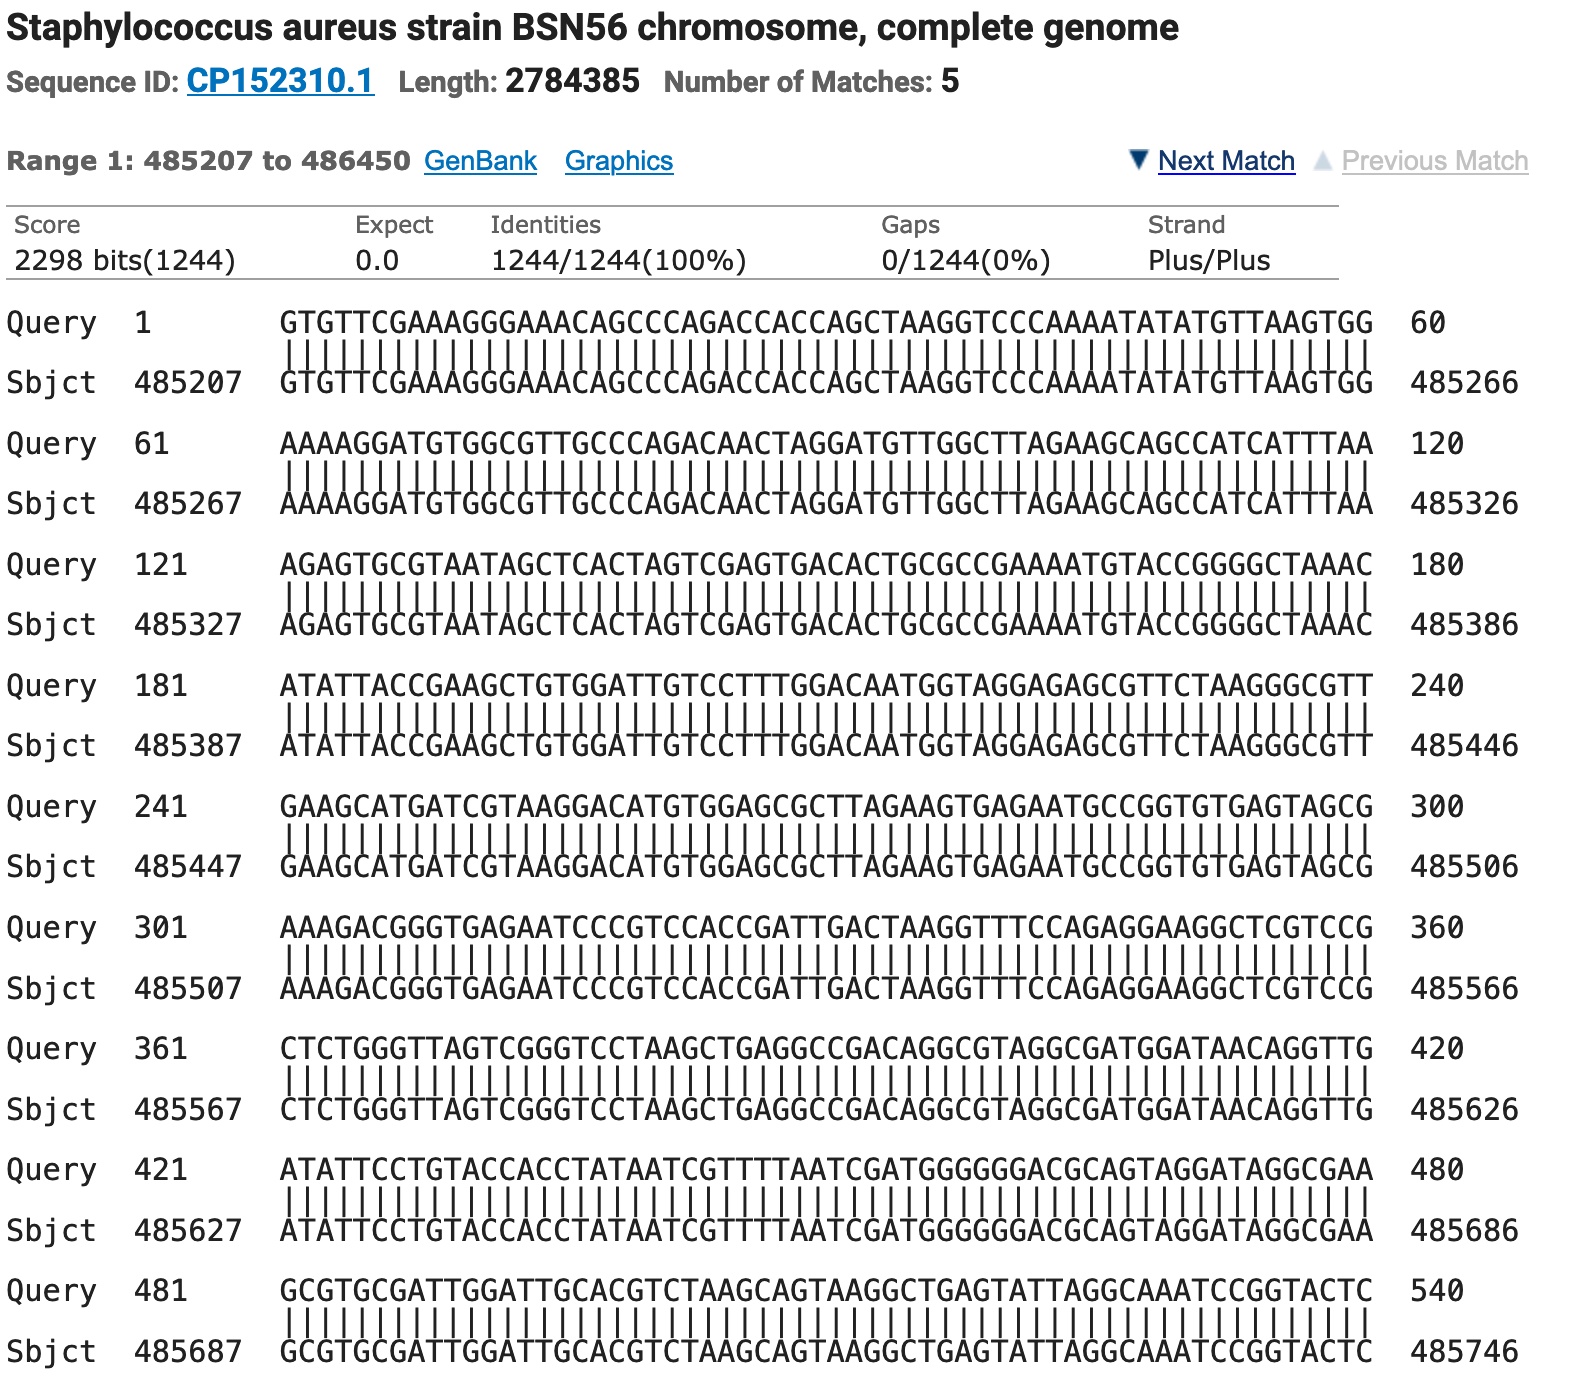![sample9_rez.png](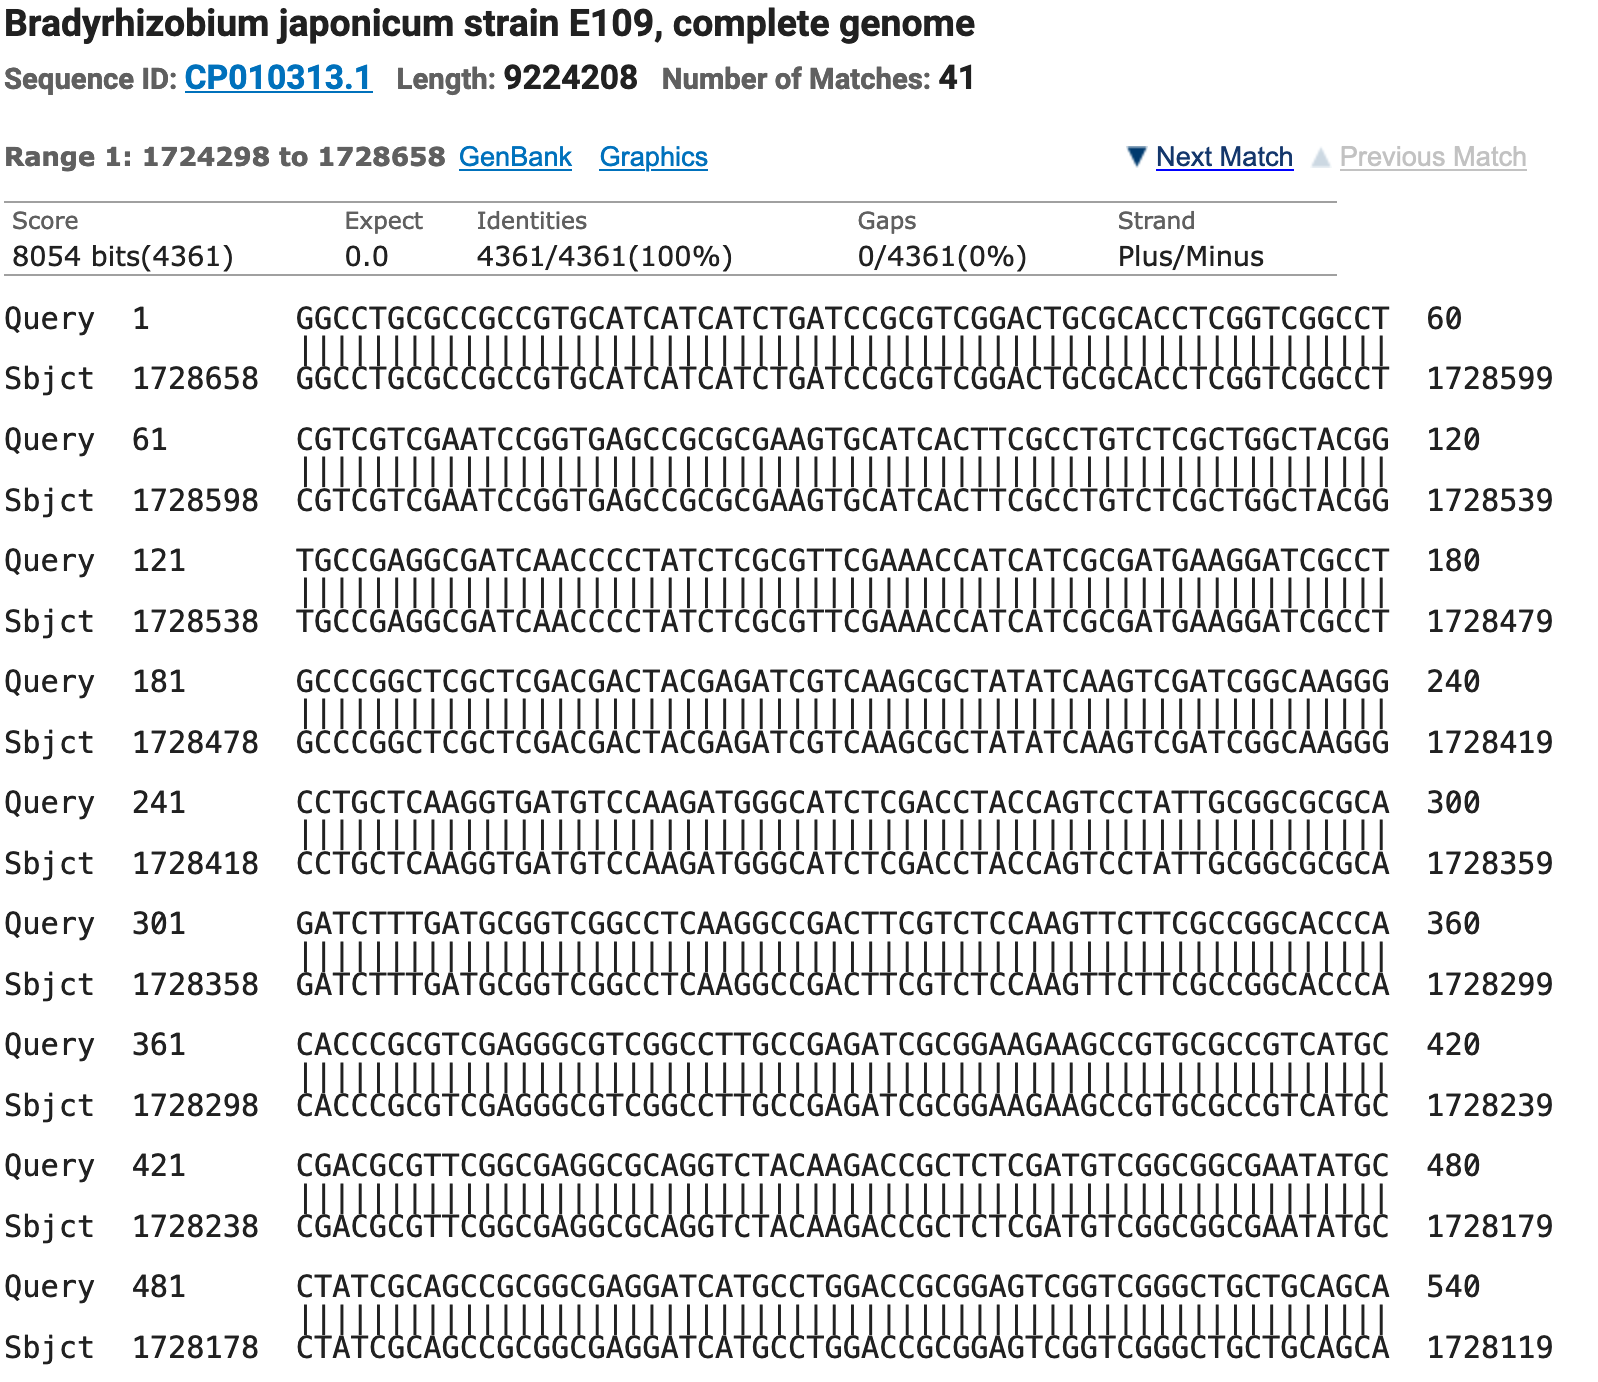![sample7_rez.png](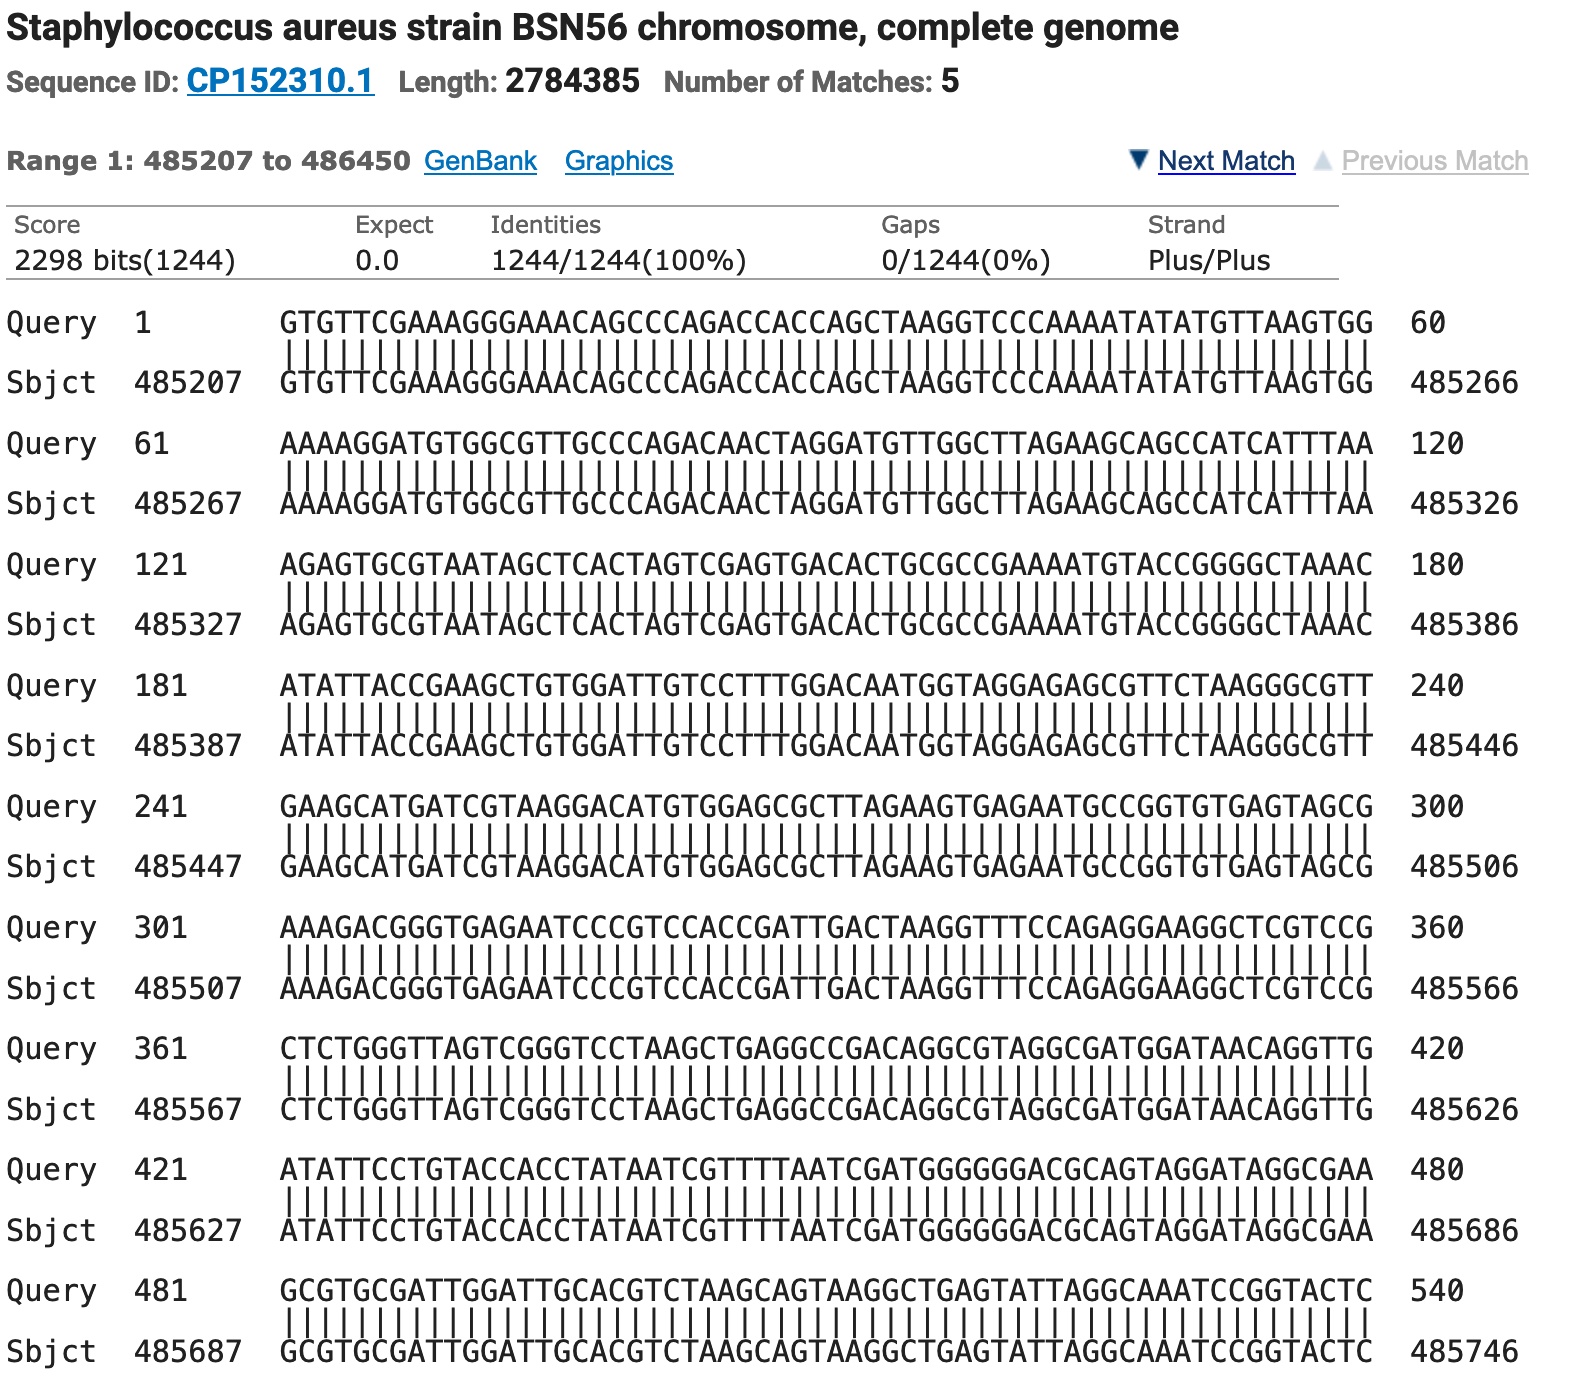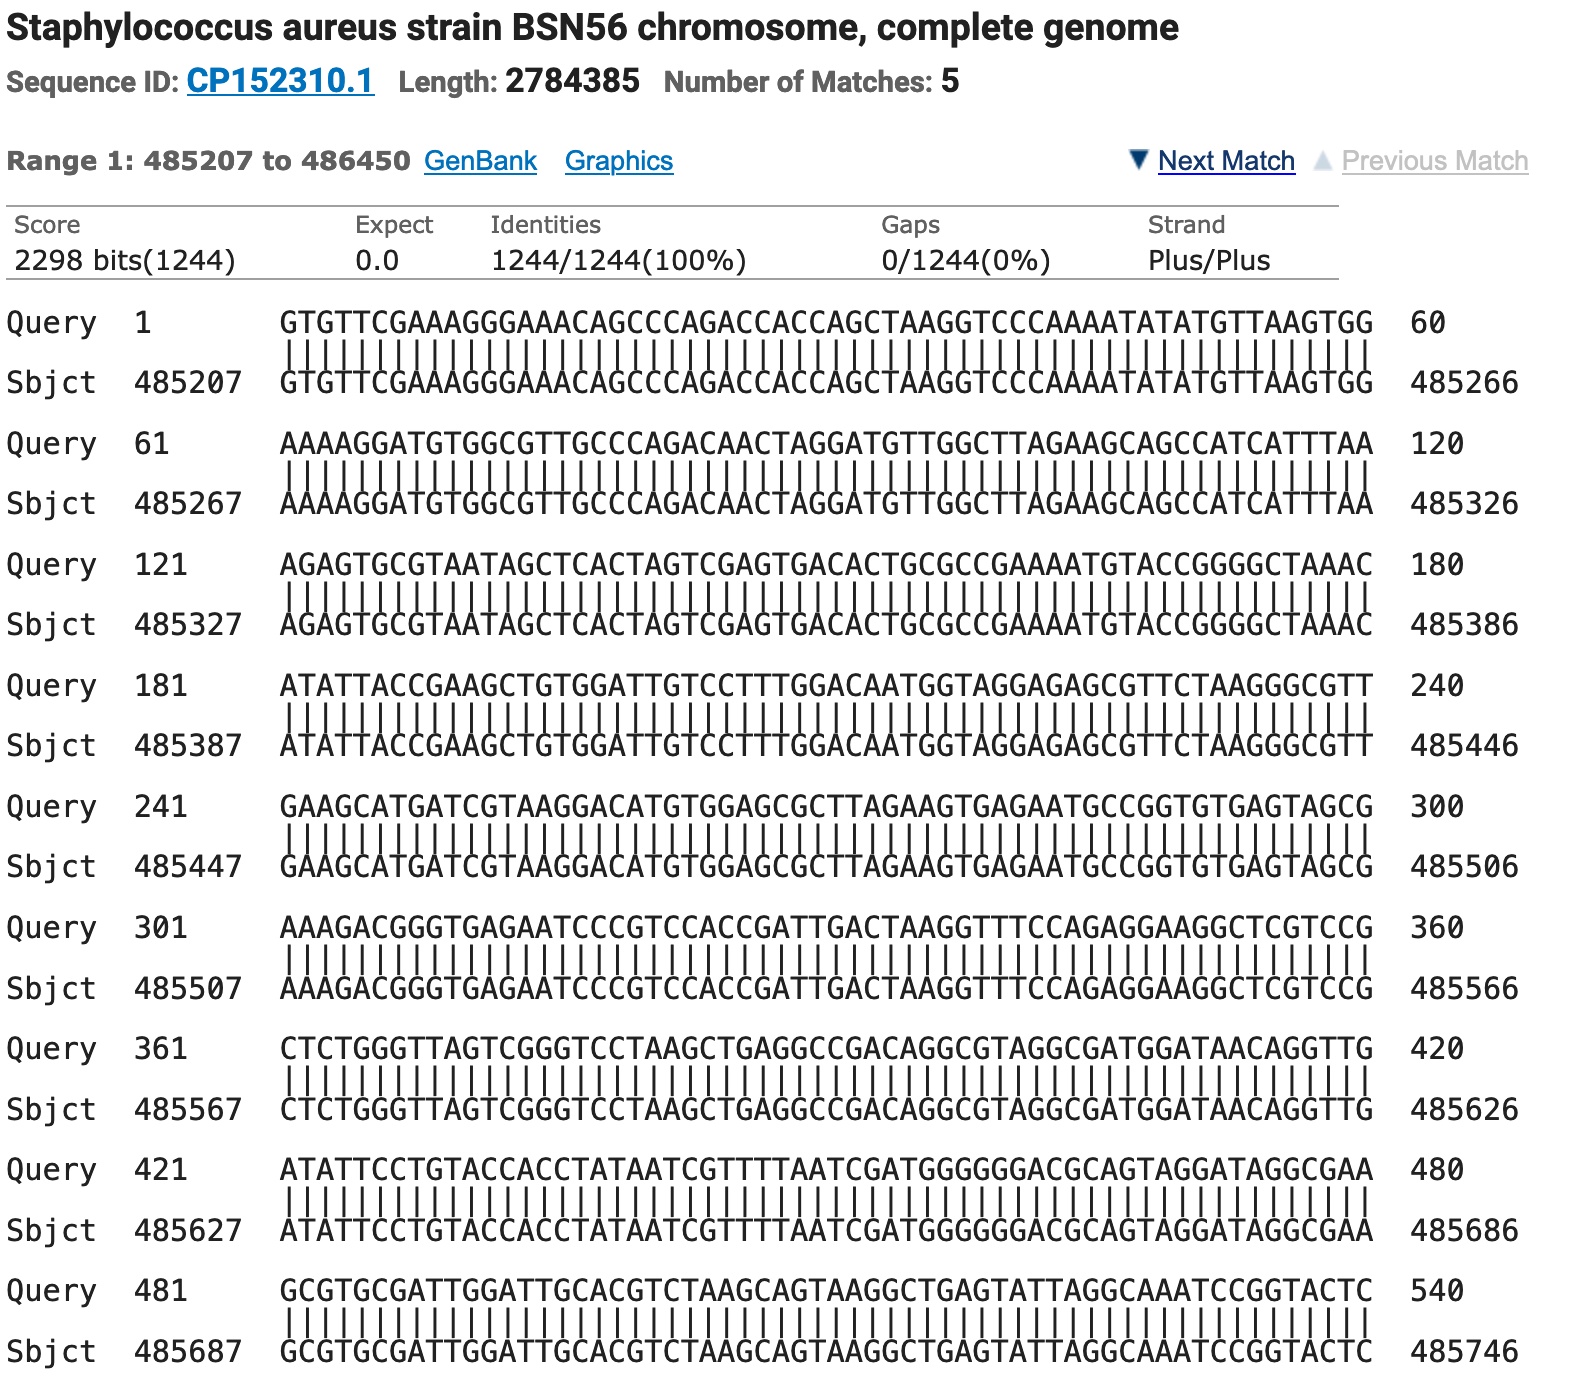)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pysam
!pip install crcmod
!apt-get install samtools

In [ ]:
### picard
!wget https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

### GATK
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!R -e 'install.packages(c("gplots", "gsalib"))'

In [ ]:
#### downloading HG0096.chr20.sorted bam
!gdown --id 1-0U11U1Z3Dp8vLHoZOtagQl25dFdza-C

In [ ]:
!gsutil ls gs://genomics-public-data

!gsutil ls gs://genomics-public-data/resources/broad/hg38/v0

!wget https://storage.googleapis.com/genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta

!git clone https://github.com/lh3/bwa.git
!cd bwa && make

1. [2 boda] Izvršiti kontrolu kvaliteta FASTQ fajlova alatom FastQC. Priložiti izvrštaj i diskutovati rezultate (da li je neki od kriterijuma koje analizira FastQC označen kao problematičan, i šta taj kriterijum znači?)


In [ ]:
import os
os.environ['PATH'] += ":/content/FastQC/"

fastq_files = [
    '/content/drive/My Drive/bioinf/sample_7.chrom11.exome.pe1.fq',
    '/content/drive/My Drive/bioinf/sample_7.chrom11.exome.pe2.fq',
    '/content/drive/My Drive/bioinf/sample_9.chrom11.exome.pe1.fq',
    '/content/drive/My Drive/bioinf/sample_9.chrom11.exome.pe2.fq'
]

import subprocess

def run_fastqc(fastq_files):
    for fastq_file in fastq_files:
        subprocess.run(["/content/FastQC/fastqc", fastq_file])

run_fastqc(fastq_files)

def display_fastqc_results(fastq_files):
    for fastq_file in fastq_files:
        report_file = fastq_file.replace(".fq", "_fastqc.html")
        report_path = "/content/" + report_file.split('/')[-1]
        if os.path.exists(report_path):
            print(f"FastQC report generated: {report_path}")
        else:
            print(f"Report not found for {fastq_file}")

display_fastqc_results(fastq_files)

2. [3 boda] Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:

In [ ]:
import os
import subprocess

!gsutil cp -r gs://genomics-public-data/resources/broad/hg38/v0 .

# Definisanje uzoraka i odgovarajućih fajlova
samples = {
    "sample9": {
        "fq1": "/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq",
        "fq2": "/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq",
        "sam": "sample9.sam",
        "bam": "sample9.bam",
        "sorted_bam": "sample9.sorted.bam"
    },
    "sample7": {
        "fq1": "/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq",
        "fq2": "/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq",
        "sam": "sample7.sam",
        "bam": "sample7.bam",
        "sorted_bam": "sample7.sorted.bam"
    }
}

# Mapiranje i obrada za svaki uzorak
for sample, files in samples.items():
    # Mapiranje sekvenciranih readova na referentni genom pomoću BWA Mem
    subprocess.run([
        "bwa/bwa", "mem", "-M", "-R", f"@RG\\tID:1\\tPL:Illumina\\tSM:{sample}",
        "-o", files["sam"], "/content/v0/Homo_sapiens_assembly38.fasta",
        files["fq1"], files["fq2"]
    ])

    # Konvertovanje SAM fajla u BAM format pomoću Samtools
    subprocess.run(["samtools", "view", "-b", "-o", files["bam"], files["sam"]])

    # Sortiranje BAM fajla
    subprocess.run(["samtools", "sort", "-o", files["sorted_bam"], files["bam"]])

    # Indeksiranje sortiranog BAM fajla
    subprocess.run(["samtools", "index", files["sorted_bam"]])

2a. Koliko je readova uspešno mapirano?

In [ ]:
import pysam

# Definisanje uzoraka i odgovarajućih sortirani BAM fajlova
samples = {
    "sample9": "sample9.sorted.bam",
    "sample7": "sample7.sorted.bam"
}

# Funkcija za brojanje uspešno mapiranih readova
def count_mapped_reads(bam_file):
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        return sum(not read.is_unmapped for read in bam)

# Iteracija kroz uzorke i prikaz broja uspešno mapiranih readova za svaki uzorak
for sample, bam_file in samples.items():
    mapped_reads = count_mapped_reads(bam_file)
    print(f"Uspesno je mapirano za {sample}: {mapped_reads}")


Uspesno je mapirano za sample9: 6758799
Uspesno je mapirano za sample7: 6435712


2b. Koliko je parova readova mapirano tako da su oba para mapirana?

In [ ]:
import pysam

# Definisanje uzoraka i odgovarajućih sortirani BAM fajlova
samples = {
    "sample9": "sample9.sorted.bam",
    "sample7": "sample7.sorted.bam"
}

# Funkcija za brojanje readova tako da su oba para mapirana
def count_properly_paired_reads(bam_file):
    br = 0
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for read in bam:
            if read.is_proper_pair:
                br += 1
    return br

# Iteracija kroz uzorke
for sample, bam_file in samples.items():
    properly_paired_reads = count_properly_paired_reads(bam_file)
    print(f"Broj readova tako da su oba para mapirana za {sample}: {properly_paired_reads}")


Broj readova tako da su oba para mapirana za sample9: 6706777
Broj readova tako da su oba para mapirana za sample7: 6358855


2c. Nacrtati histogram dužina sekvenciranih fragmenata (*template_length*).

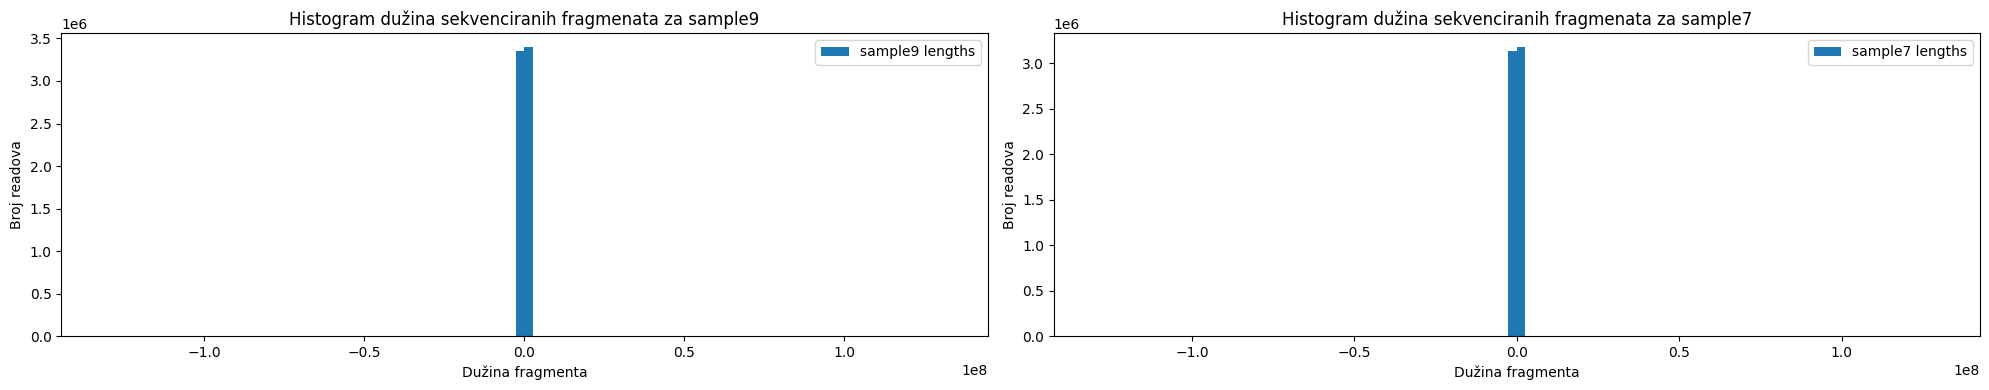

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pysam

# Definisanje uzoraka i odgovarajućih sortirani BAM fajlova
samples = {
    "sample9": "sample9.sorted.bam",
    "sample7": "sample7.sorted.bam"
}

# Funkcija za dobijanje dužina sekvenciranih fragmenata (template_length)
def get_template_lengths(bam_file):
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        return [record.template_length for record in bam.fetch('chr11')]

# Postavljanje figure za crtanje
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Iteracija kroz uzorke i crtanje histograma za svaki uzorak
for idx, (sample, bam_file) in enumerate(samples.items()):
    template_lengths = get_template_lengths(bam_file)
    lengths = np.array(template_lengths)

    ax = axes[idx]
    ax.hist(lengths, label=f'{sample} lengths', bins=100)
    ax.legend()
    ax.set_title(f'Histogram dužina sekvenciranih fragmenata za {sample}')
    ax.set_xlabel('Dužina fragmenta')
    ax.set_ylabel('Broj readova')

# Prikazivanje figure
plt.tight_layout()
plt.show()

3. [4 boda] Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)

In [ ]:
import subprocess
import os

# Definisanje uzoraka i odgovarajućih fajlova
samples = {
    "sample9": {
        "sorted_bam": "sample9.sorted.bam",
        "deduped_bam": "sample9.deduped.bam",
        "dup_metrics": "sample9.dup_metrics.txt",
        "report": "sample9.report.tsv"
    },
    "sample7": {
        "sorted_bam": "sample7.sorted.bam",
        "deduped_bam": "sample7.deduped.bam",
        "dup_metrics": "sample7.dup_metrics.txt",
        "report": "sample7.report.tsv"
    }
}

# Markiranje duplikata
for sample, files in samples.items():
    subprocess.run([
        "java", "-jar", "picard.jar", "MarkDuplicates",
        f"I={files['sorted_bam']}",
        f"O={files['deduped_bam']}",
        f"M={files['dup_metrics']}"
    ])

    subprocess.run([
        "grep", "-A2", "'## METRICS CLASS'", files['dup_metrics'], "|",
        "grep", "-v", "'## METRICS CLASS'", ">", files['report']
    ])


3a. Koliki su procenati PCR i optičkih duplikata?

In [ ]:
import pandas as pd

# Definisanje uzoraka i odgovarajućih fajlova
samples = {
    "sample9": {
        "dup_metrics": "sample9.dup_metrics.txt"
    },
    "sample7": {
        "dup_metrics": "sample7.dup_metrics.txt"
    }
}

# Funkcija za čitanje dup_metrics i izračunavanje procenata duplikata
def calculate_duplicate_percentage(dup_metrics_file):
    with open(dup_metrics_file, 'r') as f:
        lines = f.readlines()

    metrics_start = False
    metrics = []
    for line in lines:
        if line.startswith("## METRICS CLASS"):
            metrics_start = True
        elif metrics_start and not line.startswith("## METRICS CLASS"):
            metrics.append(line.strip().split('\t'))
            if len(metrics) > 2:  # Uzmi samo prva dva reda nakon zaglavlja
                break

    if len(metrics) < 2:
        return None

    header = metrics[0]
    values = metrics[1]

    metrics_dict = dict(zip(header, values))

    total_reads = int(metrics_dict['UNPAIRED_READS_EXAMINED']) + int(metrics_dict['READ_PAIRS_EXAMINED']) * 2
    duplicate_reads = int(metrics_dict['UNPAIRED_READ_DUPLICATES']) + int(metrics_dict['READ_PAIR_DUPLICATES']) * 2
    optical_duplicates = int(metrics_dict['READ_PAIR_OPTICAL_DUPLICATES']) * 2

    pcr_dup_percentage = (duplicate_reads / total_reads) * 100
    optical_dup_percentage = (optical_duplicates / total_reads) * 100

    return pcr_dup_percentage, optical_dup_percentage

# Iteracija kroz uzorke i prikaz procenata duplikata za svaki uzorak
for sample, files in samples.items():
    pcr_dup_percentage, optical_dup_percentage = calculate_duplicate_percentage(files['dup_metrics'])
    print(f"Procenat PCR duplikata za {sample}: {pcr_dup_percentage:.2f}%")
    print(f"Procenat optičkih duplikata za {sample}: {optical_dup_percentage:.2f}%")


Procenat PCR duplikata za sample9: 7.17%
Procenat optičkih duplikata za sample9: 0.00%
Procenat PCR duplikata za sample7: 6.86%
Procenat optičkih duplikata za sample7: 0.00%


Rekalibracija kvaliteta baza

In [ ]:
# Definisanje putanja do datoteka i parametara
samples = {
    "sample9": {
        "deduped_bam": "/content/sample9.deduped.bam",
        "recalibrated_bam": "/content/sample9.recalibrated.bam",
        "recal_table": "/content/sample9.recal.table",
        "post_recal_table": "/content/sample9.post_recal.table",
        "compare_plots": "/content/sample9.compare.pdf"
    },
    "sample7": {
        "deduped_bam": "/content/sample7.deduped.bam",
        "recalibrated_bam": "/content/sample7.recalibrated.bam",
        "recal_table": "/content/sample7.recal.table",
        "post_recal_table": "/content/sample7.post_recal.table",
        "compare_plots": "/content/sample7.compare.pdf"
    }
}

dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'
gatk = '/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

# Rekalibracija kvaliteta baza
for sample, files in samples.items():
    ibam = files['deduped_bam']
    obam = files['recalibrated_bam']
    recal = files['recal_table']
    post_recal = files['post_recal_table']
    compare_plots = files['compare_plots']

    !java -jar {gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}
    !java -jar {gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}
    !java -jar {gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}
    !java -jar {gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots {compare_plots}


19:49:26.953 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
19:49:27.298 INFO  BaseRecalibrator - ------------------------------------------------------------
19:49:27.299 INFO  BaseRecalibrator - The Genome Analysis Toolkit (GATK) v4.1.4.1
19:49:27.299 INFO  BaseRecalibrator - For support and documentation go to https://software.broadinstitute.org/gatk/
19:49:27.299 INFO  BaseRecalibrator - Executing as root@d776c9d7d14b on Linux v6.1.85+ amd64
19:49:27.299 INFO  BaseRecalibrator - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
19:49:27.300 INFO  BaseRecalibrator - Start Date/Time: June 4, 2024 at 7:49:26 PM UTC
19:49:27.300 INFO  BaseRecalibrator - ------------------------------------------------------------
19:49:27.300 INFO  BaseRecalibrator - ------------------------------------------------------------
19:49:27.301 INFO  BaseRecal

4. [4 boda] Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama).

In [ ]:
# Definisanje putanja do datoteka i parametara
samples = {
    "sample9": {
        "recalibrated_bam": "/content/sample9.recalibrated.bam",
        "vcf": "/content/sample9.vcf",
        "snp_vcf": "/content/sample9.snp.vcf",
        "indel_vcf": "/content/sample9.indel.vcf",
        "snp_filtered_vcf": "/content/sample9.snp.filtered.vcf",
        "indel_filtered_vcf": "/content/sample9.indel.filtered.vcf",
        "filtered_vcf": "/content/sample9.filtered.vcf"
    },
    "sample7": {
        "recalibrated_bam": "/content/sample7.recalibrated.bam",
        "vcf": "/content/sample7.vcf",
        "snp_vcf": "/content/sample7.snp.vcf",
        "indel_vcf": "/content/sample7.indel.vcf",
        "snp_filtered_vcf": "/content/sample7.snp.filtered.vcf",
        "indel_filtered_vcf": "/content/sample7.indel.filtered.vcf",
        "filtered_vcf": "/content/sample7.filtered.vcf"
    }
}

gatk = '/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'
snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0"

# Identifikacija mutacija i filtriranje za svaki uzorak
for sample, files in samples.items():
    ibam = files['recalibrated_bam']
    ovcf = files['vcf']
    isvcf = files['snp_vcf']
    iivcf = files['indel_vcf']
    osvcf = files['snp_filtered_vcf']
    oivcf = files['indel_filtered_vcf']
    ofiltered_vcf = files['filtered_vcf']

    # HaplotypeCaller
    !java -jar {gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

    # Filtriranje SNP-ova
    !java -jar {gatk} SelectVariants -R {ref} -V {ovcf} -O {isvcf} --select-type-to-include SNP
    !java -jar {gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

    # Filtriranje INDEL-ova
    !java -jar {gatk} SelectVariants -R {ref} -V {ovcf} -O {iivcf} --select-type-to-include INDEL
    !java -jar {gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

    # Spajanje filtriranih varijanti
    !java -jar {gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ofiltered_vcf}


Streaming output truncated to the last 5000 lines.
20:37:02.428 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.428 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.428 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.428 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.439 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.439 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
20:37:02.440 WARN  

In [ ]:
def is_filtered(variant):
    return 'PASS' not in variant.filter

def is_snp(variant):
    return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
    allels = set((variant.ref, variant.alts[0]))
    return allels == {'A', 'G'} or allels == {'C', 'T'}

4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?

In [ ]:
import pysam

# putanja do filtriranih VCF fajlova
samples = {
    "sample9": "/content/sample9.filtered.vcf",
    "sample7": "/content/sample7.filtered.vcf"
}

# Iteracija kroz uzorke i ispis broja SNP-ova i INDEL-ova za svaki uzorak
for sample, ovcf in samples.items():
    snps = sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v))
    indels = sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v))
    print(f"{sample} - SNPs: {snps}")
    print(f"{sample} - INDELs: {indels}")


sample9 - SNPs: 396
sample9 - INDELs: 95
sample7 - SNPs: 317
sample7 - INDELs: 89


4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.

In [ ]:
import pysam

# putanja do filtriranih VCF fajlova
samples = {
    "sample9": "/content/sample9.filtered.vcf",
    "sample7": "/content/sample7.filtered.vcf"
}

# Iteracija kroz uzorke i ispis broja filtriranih i nefiltriranih varijanti za svaki uzorak
for sample, ovcf in samples.items():
    filtered_variants = sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v))
    unfiltered_variants = sum(1 for v in pysam.VariantFile(ovcf) if not is_filtered(v))
    print(f"{sample} - Filtrirani: {filtered_variants}")
    print(f"{sample} - Nefiltrirani: {unfiltered_variants}")


sample9 - Filtrirani: 491
sample9 - Nefiltrirani: 16244
sample7 - Filtrirani: 406
sample7 - Nefiltrirani: 16790


4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

In [ ]:
import pysam

# putanja do filtriranih i nefiltriranih VCF fajlova
samples = {
    "sample9": {
        "unfiltered_vcf": "/content/sample9.vcf",
        "filtered_vcf": "/content/sample9.filtered.vcf"
    },
    "sample7": {
        "unfiltered_vcf": "/content/sample7.vcf",
        "filtered_vcf": "/content/sample7.filtered.vcf"
    }
}

# Iteracija kroz uzorke i izračunavanje Ti/Tv odnosa pre i posle filtriranja
for sample, files in samples.items():
    unfiltered_vcf = files["unfiltered_vcf"]
    filtered_vcf = files["filtered_vcf"]

    # Pre filtriranja
    tinF = sum(1 for v in pysam.VariantFile(unfiltered_vcf)
             if not is_filtered(v)
             and is_snp(v)
             and is_transitions(v))

    tvnF = sum(1 for v in pysam.VariantFile(unfiltered_vcf)
              if not is_filtered(v)
              and is_snp(v)
              and not is_transitions(v))

    # Posle filtriranja
    tiF = sum(1 for v in pysam.VariantFile(filtered_vcf)
             if not is_filtered(v)
             and is_snp(v)
             and is_transitions(v))

    tvF = sum(1 for v in pysam.VariantFile(filtered_vcf)
              if not is_filtered(v)
              and is_snp(v)
              and not is_transitions(v))

    # Ispis rezultata
    print(f"{sample} - Pre filtriranja - Ti: {tinF}, Tv: {tvnF}, Ti/Tv odnos: {tinF/tvnF if tvnF != 0 else 'N/A'}")
    print(f"{sample} - Posle filtriranja - Ti: {tiF}, Tv: {tvF}, Ti/Tv odnos: {tiF/tvF if tvF != 0 else 'N/A'}")


sample9 - Pre filtriranja - Ti: 9836, Tv: 5077, Ti/Tv odnos: 1.9373645853850698
sample9 - Posle filtriranja - Ti: 9630, Tv: 4884, Ti/Tv odnos: 1.9717444717444716
sample7 - Pre filtriranja - Ti: 9996, Tv: 5235, Ti/Tv odnos: 1.90945558739255
sample7 - Posle filtriranja - Ti: 9834, Tv: 5080, Ti/Tv odnos: 1.9358267716535433


5. [3 boda] Anotirati mutacije alatom Funcotator

In [ ]:
import os
import subprocess
import pysam

# Preskakanje GCE provere
os.environ["NO_GCE_CHECK"] = "true"

# Preuzimanje Funcotator data sources
!java -jar /content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar FuncotatorDataSourceDownloader --germline --extract-after-download


!tar -xzf funcotator_dataSources.v1.6.20190124g.tar.gz


In [ ]:
# Putanje
samples = {
    "sample9": {
        "filtered_vcf": "/content/sample9.filtered.vcf",
        "annotated_vcf": "/content/sample9.annotated.vcf"
    },
    "sample7": {
        "filtered_vcf": "/content/sample7.filtered.vcf",
        "annotated_vcf": "/content/sample7.annotated.vcf"
    }
}

gatk = '/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'
func = 'funcotator_dataSources.v1.6.20190124g/'

# Anotacija varijanti pomoću Funcotator-a
for sample, files in samples.items():
    ivcf = files["filtered_vcf"]
    ovcf = files["annotated_vcf"]

    !java -jar {gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

    reader = pysam.VariantFile(ovcf)
    description = reader.header.info['FUNCOTATION'].description
    print(f"{sample} - FUNCOTATION description: {description}")
    functotations = description[73:].split('|')
    print('\n'.join(functotations))


Streaming output truncated to the last 5000 lines.
21:11:01.302 WARN  FuncotatorUtils - createAminoAcidSequence given a coding sequence of length not divisible by 3.  Dropping bases from the end: 1 (size=3355, alt allele: G)
21:11:01.303 WARN  FuncotatorUtils - createAminoAcidSequence given a coding sequence of length not divisible by 3.  Dropping bases from the end: 2 (size=4193, ref allele: A)
21:11:01.303 WARN  FuncotatorUtils - createAminoAcidSequence given a coding sequence of length not divisible by 3.  Dropping bases from the end: 2 (size=4193, alt allele: G)
21:11:01.303 WARN  FuncotatorUtils - createAminoAcidSequence given a coding sequence of length not divisible by 3.  Dropping bases from the end: 2 (size=3119, ref allele: A)
21:11:01.304 WARN  FuncotatorUtils - createAminoAcidSequence given a coding sequence of length not divisible by 3.  Dropping bases from the end: 2 (size=3119, alt allele: G)
21:11:01.304 WARN  FuncotatorUtils - createAminoAcidSequence given a coding seq

5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija *ClinVar_VCF_CLNSIG*, koliko mutacija je označeno kao *Benign*, *Likely_benign*, itd.)-.

In [ ]:
import io
import pysam


samples = {
    "sample9": {
        "annotated_vcf": "/content/sample9.annotated.vcf"
    },
    "sample7": {
        "annotated_vcf": "/content/sample7.annotated.vcf"
    }
}

encodings = ['utf-8', 'latin1', 'cp1252']

# Provera broja varijanti po kategorijama za svaki uzorak
for sample, files in samples.items():
    ovcf = files["annotated_vcf"]
    b = 0
    lb = 0
    b_lb = 0

    for encoding in encodings:
        try:
            with open(ovcf, 'r', encoding=encoding) as vcf_file:
                vcf_wrapper = io.TextIOWrapper(vcf_file, encoding=encoding)
                vcf_reader = pysam.VariantFile(vcf_wrapper)

                for variant in vcf_reader:
                    ann = {x: y for x, y in zip(functotations, variant.info['FUNCOTATION'][0][1:-1].split('|'))}

                    if ann['ClinVar_VCF_CLNSIG'] == 'Benign':
                        b += 1
                    elif ann['ClinVar_VCF_CLNSIG'] == 'Likely_benign':
                        lb += 1
                    elif ann['ClinVar_VCF_CLNSIG'] == 'Benign/Likely_benign':
                        b_lb += 1

            break  # Izlazimo iz petlje ako je uspešno otvoren i dekodiran fajl

        except UnicodeDecodeError:
            continue  # Pokušavamo sa sledećim enkodingom ako se javi UnicodeDecodeError

    print(f"{sample} - Benign:")
    print(b)
    print(f"{sample} - Likely_benign:")
    print(lb)
    print(f"{sample} - Benign/Likely_benign:")
    print(b_lb)


sample9 - Benign:
492
sample9 - Likely_benign:
51
sample9 - Benign/Likely_benign:
84
sample7 - Benign:
435
sample7 - Likely_benign:
33
sample7 - Benign/Likely_benign:
57


6. [4 boda] Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

In [ ]:
!sudo apt-get install autotools-dev automake
!git clone https://github.com/bcgsc/abyss.git
!cd abyss && ./autogen.sh
!cd abyss && ./configure
!cd abyss && make
!cd abyss && sudo make install

!sudo apt-get install abyss
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.10.0/setup-apt.sh
!sudo sh setup-apt.sh


In [ ]:
# Generisanje praznih FASTQ fajlova za oba samplea
samples = ["sample7", "sample9"]

for sample in samples:
    fastq_file = f'/content/drive/MyDrive/{sample}_unmapped.fastq'
    with open(fastq_file, 'w') as f:
        pass
    print(f'Prazan FASTQ fajl {fastq_file} je uspešno generisan.')

Prazan FASTQ fajl /content/drive/MyDrive/sample7_unmapped.fastq je uspešno generisan.
Prazan FASTQ fajl /content/drive/MyDrive/sample9_unmapped.fastq je uspešno generisan.


In [ ]:
!pip install Bio

In [ ]:
from Bio import SeqIO
import pysam
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# putanja do BAM fajlova
samples = {
    "sample9": "/content/sample9.recalibrated.bam",
    "sample7": "/content/sample7.recalibrated.bam"
}

for sample, bam_file in samples.items():
    # Otvaranje BAM fajla za čitanje
    bam = pysam.AlignmentFile(bam_file, 'rb')

    # prazna lista za čuvanje ne-mapiranih readova
    unmapped_reads = []

    # Iteracija kroz svaki read u BAM fajlu
    for read in bam.fetch():
        if read.is_unmapped:  # da li je read ne-mapiran
            unmapped_reads.append(read.query_sequence)

    bam.close()

    # Putanja do izlaznog FASTQ fajla
    fastq_file = f'/content/drive/MyDrive/{sample}_unmapped.fastq'

    # Kreiranje i čuvanje FASTQ zapisa za nemapirane readove
    seq_records = []
    for i, seq in enumerate(unmapped_reads):
        seq_record = SeqRecord(Seq(seq), id=f'read{i+1}', description='')
        seq_record.letter_annotations["phred_quality"] = [40] * len(seq)  # Postavljamo podrazumevanu vrednost kvaliteta
        seq_records.append(seq_record)

    SeqIO.write(seq_records, fastq_file, 'fastq')
    print(f'FASTQ fajl sa nemapiranim readovima je uspešno kreiran: {fastq_file}')


FASTQ fajl sa nemapiranim readovima je uspešno kreiran: /content/drive/MyDrive/sample9_unmapped.fastq
FASTQ fajl sa nemapiranim readovima je uspešno kreiran: /content/drive/MyDrive/sample7_unmapped.fastq


In [ ]:
!sudo apt-get update
!sudo apt-get install -y abyss

In [ ]:
!abyss-pe name=sample7 k=64 in='/content/sample7_unmapped.fastq'
!abyss-pe name=sample9 k=64 in='/content/sample9_unmapped.fastq'


ABYSS -k64 -q3    --coverage-hist=coverage.hist -s sample7-bubbles.fa  -o sample7-1.fa /content/sample7_unmapped.fastq 
ABySS 2.3.1
ABYSS -k64 -q3 --coverage-hist=coverage.hist -s sample7-bubbles.fa -o sample7-1.fa /content/sample7_unmapped.fastq
Reading `/content/sample7_unmapped.fastq'...
`/content/sample7_unmapped.fastq': discarded 20542 reads shorter than 64 bases
`/content/sample7_unmapped.fastq': discarded 45 reads containing non-ACGT characters
Loaded 9920758 k-mer
Minimum k-mer coverage is 40
Using a coverage threshold of 2...
The median k-mer coverage is 3
The reconstruction is 1979235
The k-mer coverage threshold is 1.73205
Setting parameter e (erode) to 2
Setting parameter E (erodeStrand) to 0
Setting parameter c (coverage) to 2
Generating adjacency
Added 19936219 edges.
Eroding tips
Eroded 5222339 tips.
Eroded 0 tips.
Pruning tips shorter than 1 bp...
Pruned 1111 k-mer in 1111 tips.
Pruning tips shorter than 2 bp...
Pruned 1111 k-mer in 572 tips.
Pruning tips shorter than 4

In [ ]:
import os
import pysam

# putanja do skafolda
samples = {
    "sample9": "/content/sample9_assembly-scaffolds.fa",
    "sample7": "/content/sample7_assembly-scaffolds.fa"
}

for sample, scaffold_fasta in samples.items():
    if not os.path.exists(scaffold_fasta):
        print(f"Fajl {scaffold_fasta} ne postoji!")
    else:
        freader = pysam.FastaFile(scaffold_fasta)

        # najduzi skafold
        max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]
        print(f"Najduži skafold za {sample}: {max_ref[1]} (dužina: {max_ref[0]})")

        # sekvenca najduzeg skafolda
        longest_scaffold_sequence = freader.fetch(max_ref[1])

        # fajl sa najduzim skafoldom
        longest_scaffold_file = f"/content/{sample}_longest_scaffold.fa"
        with open(longest_scaffold_file, 'w') as f:
            f.write(f">{max_ref[1]}\n{longest_scaffold_sequence}\n")
        print(f"Najduži skafold za {sample} je sačuvan u {longest_scaffold_file}")


Najduži skafold za sample9: 3987 (dužina: 4361)
Najduži skafold za sample9 je sačuvan u /content/sample9_longest_scaffold.fa
Najduži skafold za sample7: 2743 (dužina: 1263)
Najduži skafold za sample7 je sačuvan u /content/sample7_longest_scaffold.fa


Blast rezultati (sample7 prva slika, sample9 druga slika)

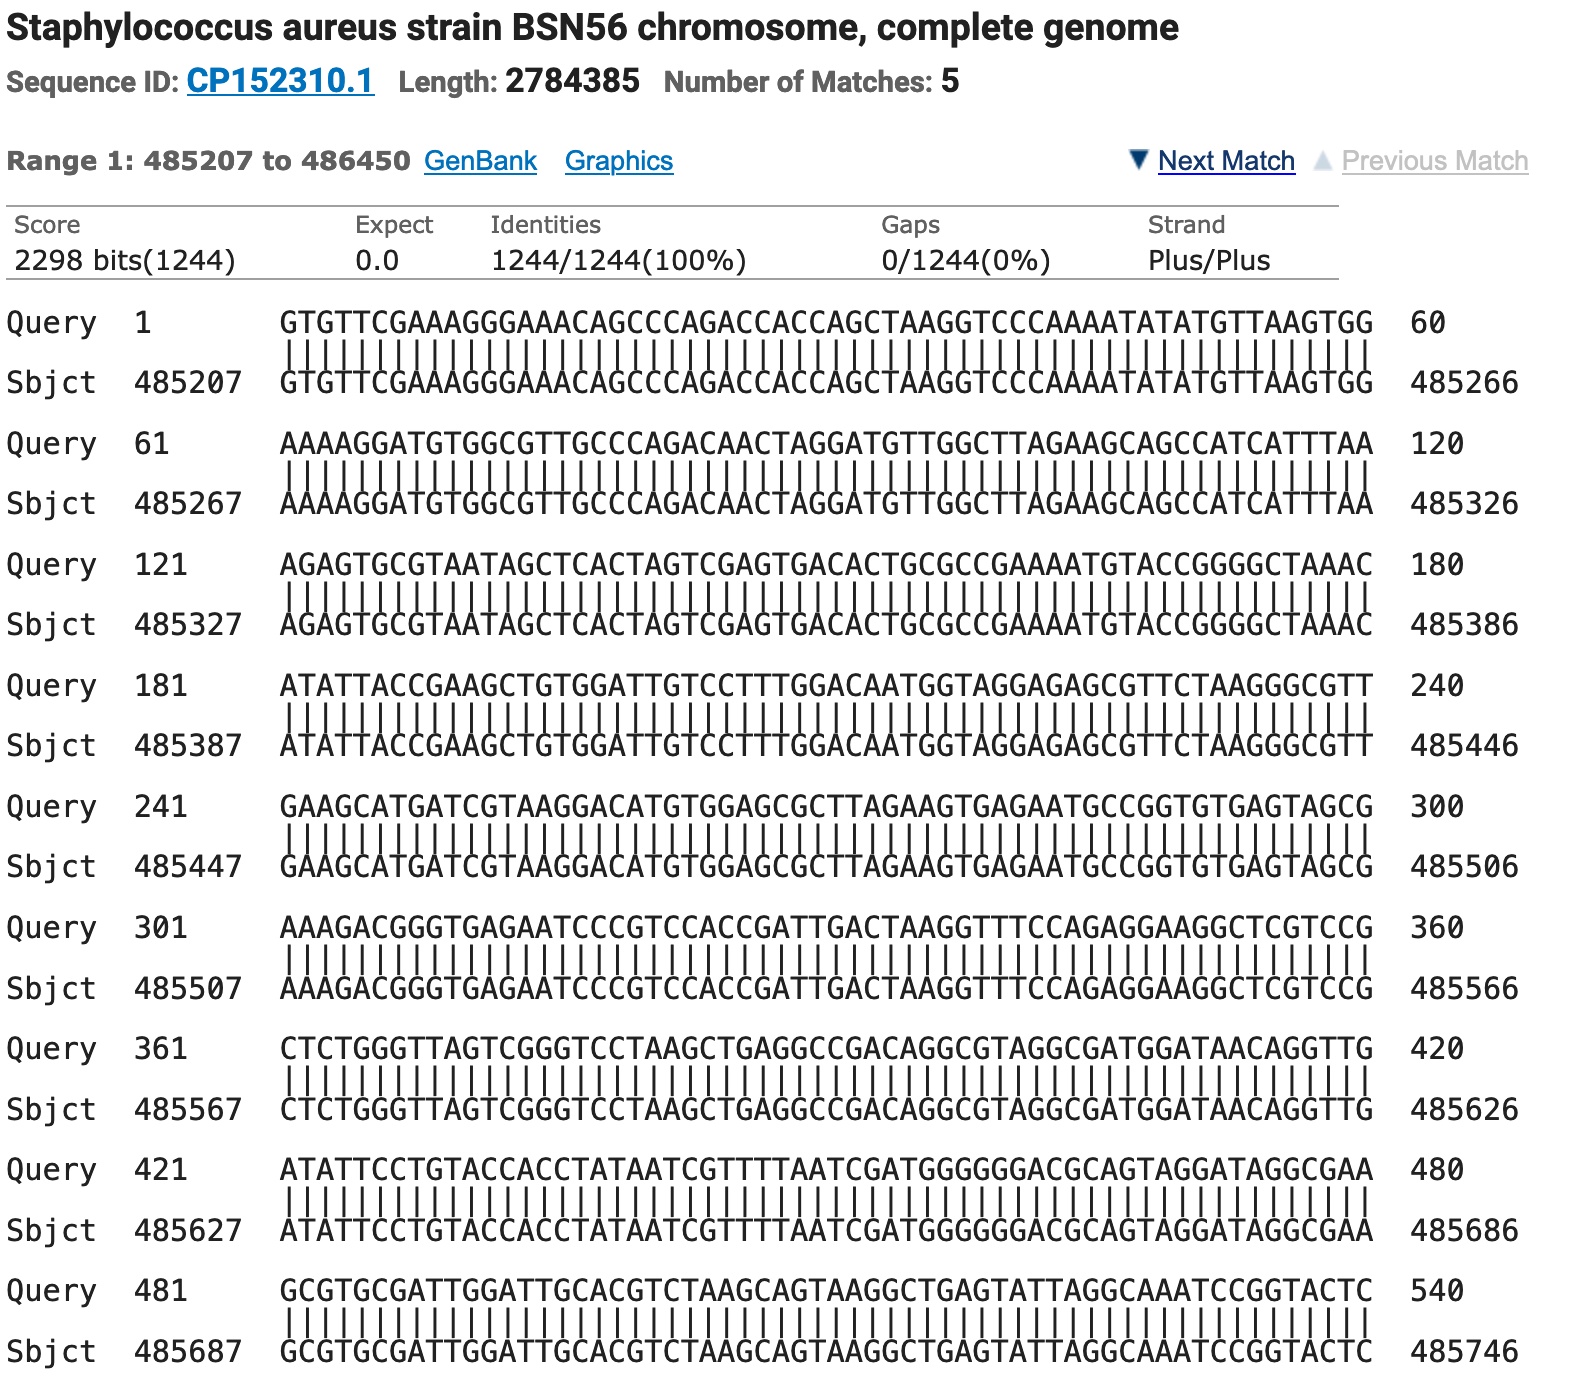
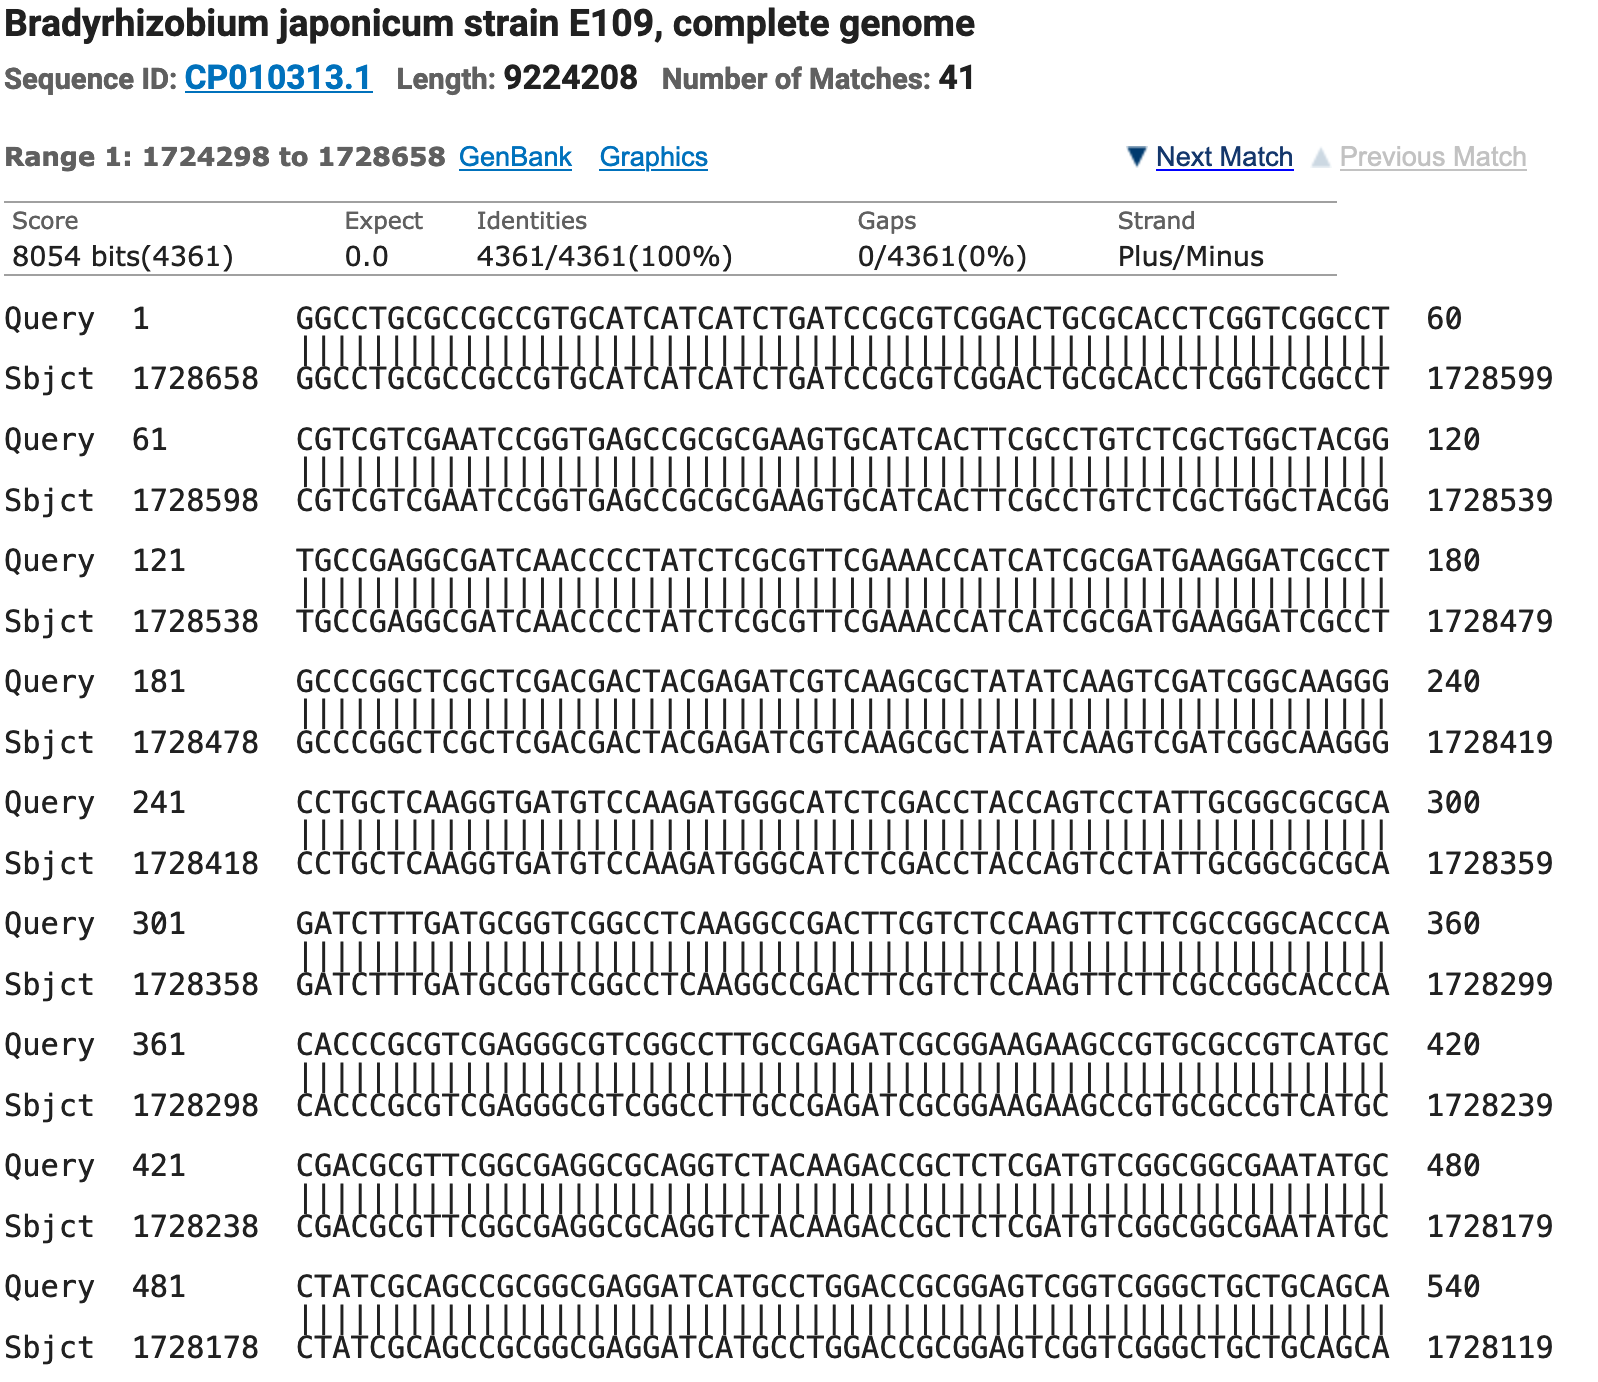